# DQN

## libraries and data

In [1]:
# from google.colab import drive
import sys, os
# import atari_py

#mount google drive
# drive.mount('/content/drive', force_remount=False)
cwd = os.getcwd()

In [2]:
%%capture
os.chdir(cwd+"/common")
!python3 -m atari_py.import_roms ../Roms
# !pip install gym pyvirtualdisplay > /dev/null 2>&1
# !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

## Algorithm

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

import gym
import numpy as np

import math, random
from wrappers import make_atari, wrap_deepmind, wrap_pytorch

/home/zhanghao/.local/lib/python3.8/site-packages/ale_py/roms/__init__.py:94: DeprecationWarning: Automatic importing of atari-py roms won't be supported in future releases of ale-py. Please migrate over to using `ale-import-roms` OR an ALE-supported ROM package. To make this warning disappear you can run `ale-import-roms --import-from-pkg atari_py.atari_roms`.For more information see: https://github.com/mgbellemare/Arcade-Learning-Environment#rom-management
  _RESOLVED_ROMS = _resolve_roms()


In [4]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

### Environment and parameter

In [5]:
seed = 5446
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.manual_seed_all(seed)

env_id = "Breakout-v4"
env = gym.make(env_id)
env = wrap_deepmind(env)
env = wrap_pytorch(env)

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 4000000
epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

num_frames = 50000000
batch_size = 128
gamma      = 0.99



/home/zhanghao/.local/lib/python3.8/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment Breakout-v4 is out of date. You should consider upgrading to version `v5` with the environment ID `ALE/Breakout-v5`.
  logger.warn(
A.L.E: Arcade Learning Environment (version 0.7.4+069f8bd)
[Powered by Stella]
/home/zhanghao/.local/lib/python3.8/site-packages/gym/utils/seeding.py:138: DeprecationWarning: WARN: Function `hash_seed(seed, max_bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(
/home/zhanghao/.local/lib/python3.8/site-packages/gym/utils/seeding.py:175: DeprecationWarning: WARN: Function `_bigint_from_bytes(bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(


### display epsilon over training

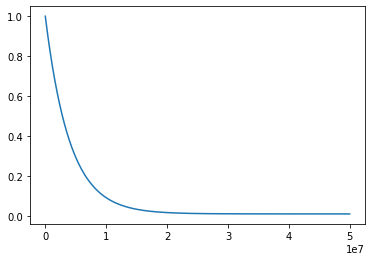

In [6]:
plt.plot([epsilon_by_frame(i) for i in range(num_frames)])

### Deep Q Network

In [7]:
class CnnDQN(nn.Module):
    def __init__(self,  num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = np.random.rand(4,84,84).shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(self.input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state = torch.FloatTensor(np.float32(state)).unsqueeze(0)
            state = state.cuda()
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action

    def eval(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        state = state.cuda()
        q_value = self.forward(state)
        action  = q_value.max(1)[1].data[0]
   
        return action

### Replay Buffer

In [8]:
# from collections import deque

# class ReplayBuffer(object):
#     def __init__(self, capacity):
#         self.buffer = deque(maxlen=capacity)
    
#     def push(self, state, action, reward, next_state, done):
#         state      = np.expand_dims(state, 0)
#         next_state = np.expand_dims(next_state, 0)
            
#         self.buffer.append((state, action, reward, next_state, done))
    
#     def sample(self, batch_size):
#         state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
#         return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
#     def __len__(self):
#         return len(self.buffer)

In [9]:
#code from openai
#https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py

import numpy as np
import random

import operator


class SegmentTree(object):
    def __init__(self, capacity, operation, neutral_element):
        """Build a Segment Tree data structure.
        https://en.wikipedia.org/wiki/Segment_tree
        Can be used as regular array, but with two
        important differences:
            a) setting item's value is slightly slower.
               It is O(lg capacity) instead of O(1).
            b) user has access to an efficient `reduce`
               operation which reduces `operation` over
               a contiguous subsequence of items in the
               array.
        Paramters
        ---------
        capacity: int
            Total size of the array - must be a power of two.
        operation: lambda obj, obj -> obj
            and operation for combining elements (eg. sum, max)
            must for a mathematical group together with the set of
            possible values for array elements.
        neutral_element: obj
            neutral element for the operation above. eg. float('-inf')
            for max and 0 for sum.
        """
        assert capacity > 0 and capacity & (capacity - 1) == 0, "capacity must be positive and a power of 2."
        self._capacity = capacity
        self._value = [neutral_element for _ in range(2 * capacity)]
        self._operation = operation

    def _reduce_helper(self, start, end, node, node_start, node_end):
        if start == node_start and end == node_end:
            return self._value[node]
        mid = (node_start + node_end) // 2
        if end <= mid:
            return self._reduce_helper(start, end, 2 * node, node_start, mid)
        else:
            if mid + 1 <= start:
                return self._reduce_helper(start, end, 2 * node + 1, mid + 1, node_end)
            else:
                return self._operation(
                    self._reduce_helper(start, mid, 2 * node, node_start, mid),
                    self._reduce_helper(mid + 1, end, 2 * node + 1, mid + 1, node_end)
                )

    def reduce(self, start=0, end=None):
        """Returns result of applying `self.operation`
        to a contiguous subsequence of the array.
            self.operation(arr[start], operation(arr[start+1], operation(... arr[end])))
        Parameters
        ----------
        start: int
            beginning of the subsequence
        end: int
            end of the subsequences
        Returns
        -------
        reduced: obj
            result of reducing self.operation over the specified range of array elements.
        """
        if end is None:
            end = self._capacity
        if end < 0:
            end += self._capacity
        end -= 1
        return self._reduce_helper(start, end, 1, 0, self._capacity - 1)

    def __setitem__(self, idx, val):
        # index of the leaf
        idx += self._capacity
        self._value[idx] = val
        idx //= 2
        while idx >= 1:
            self._value[idx] = self._operation(
                self._value[2 * idx],
                self._value[2 * idx + 1]
            )
            idx //= 2

    def __getitem__(self, idx):
        assert 0 <= idx < self._capacity
        return self._value[self._capacity + idx]


class SumSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(SumSegmentTree, self).__init__(
            capacity=capacity,
            operation=operator.add,
            neutral_element=0.0
        )

    def sum(self, start=0, end=None):
        """Returns arr[start] + ... + arr[end]"""
        return super(SumSegmentTree, self).reduce(start, end)

    def find_prefixsum_idx(self, prefixsum):
        """Find the highest index `i` in the array such that
            sum(arr[0] + arr[1] + ... + arr[i - i]) <= prefixsum
        if array values are probabilities, this function
        allows to sample indexes according to the discrete
        probability efficiently.
        Parameters
        ----------
        perfixsum: float
            upperbound on the sum of array prefix
        Returns
        -------
        idx: int
            highest index satisfying the prefixsum constraint
        """
        assert 0 <= prefixsum <= self.sum() + 1e-5
        idx = 1
        while idx < self._capacity:  # while non-leaf
            if self._value[2 * idx] > prefixsum:
                idx = 2 * idx
            else:
                prefixsum -= self._value[2 * idx]
                idx = 2 * idx + 1
        return idx - self._capacity


class MinSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(MinSegmentTree, self).__init__(
            capacity=capacity,
            operation=min,
            neutral_element=float('inf')
        )

    def min(self, start=0, end=None):
        """Returns min(arr[start], ...,  arr[end])"""

        return super(MinSegmentTree, self).reduce(start, end)

class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def push(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            
            # print(type(obs_t))
            if not isinstance(obs_t,torch.Tensor):
                obses_t.append(np.array(obs_t, copy=False))
            else:
                print(type(obs_t))
                obses_t.append(np.array(obs_t.cpu(), copy=True))

            # print(type(action))
            if not isinstance(action,torch.Tensor):
                actions.append(np.array(action, copy=False))
            else:
                actions.append(np.array(action.cpu(), copy=True))

            # print(type(reward))
            if not isinstance(reward,torch.Tensor):
                rewards.append(reward)
            else:
                rewards.append(reward.cpu())
            
            # print(type(obs_tp1))
            if not isinstance(obs_tp1,torch.Tensor):
                obses_tp1.append(np.array(obs_tp1, copy=False))
            else:
                obses_tp1.append(np.array(obs_tp1.cpu(), copy=True))

            # print(type(done))
            if not isinstance(done,torch.Tensor):
                dones.append(done)
            else:
                dones.append(done.cpu())

        return np.array(obses_t), np.array(actions), np.array(rewards), np.array(obses_tp1), np.array(dones)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)

class PrioritizedReplayBuffer(ReplayBuffer):
    def __init__(self, size, alpha):
        """Create Prioritized Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        alpha: float
            how much prioritization is used
            (0 - no prioritization, 1 - full prioritization)
        See Also
        --------
        ReplayBuffer.__init__
        """
        super(PrioritizedReplayBuffer, self).__init__(size)
        assert alpha > 0
        self._alpha = alpha

        it_capacity = 1
        while it_capacity < size:
            it_capacity *= 2

        self._it_sum = SumSegmentTree(it_capacity)
        self._it_min = MinSegmentTree(it_capacity)
        self._max_priority = 1.0

    def push(self, *args, **kwargs):
        """See ReplayBuffer.store_effect"""
        idx = self._next_idx
        super(PrioritizedReplayBuffer, self).push(*args, **kwargs)
        self._it_sum[idx] = self._max_priority ** self._alpha
        self._it_min[idx] = self._max_priority ** self._alpha

    def _sample_proportional(self, batch_size):
        res = []
        for _ in range(batch_size):
            # TODO(szymon): should we ensure no repeats?
            mass = random.random() * self._it_sum.sum(0, len(self._storage) - 1)
            idx = self._it_sum.find_prefixsum_idx(mass)
            res.append(idx)
        return res

    def sample(self, batch_size, beta):
        """Sample a batch of experiences.
        compared to ReplayBuffer.sample
        it also returns importance weights and idxes
        of sampled experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        beta: float
            To what degree to use importance weights
            (0 - no corrections, 1 - full correction)
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        weights: np.array
            Array of shape (batch_size,) and dtype np.float32
            denoting importance weight of each sampled transition
        idxes: np.array
            Array of shape (batch_size,) and dtype np.int32
            idexes in buffer of sampled experiences
        """
        assert beta > 0

        idxes = self._sample_proportional(batch_size)

        weights = []
        p_min = self._it_min.min() / self._it_sum.sum()
        max_weight = (p_min * len(self._storage)) ** (-beta)

        for idx in idxes:
            p_sample = self._it_sum[idx] / self._it_sum.sum()
            weight = (p_sample * len(self._storage)) ** (-beta)
            weights.append(weight / max_weight)
        weights = np.array(weights)
        encoded_sample = self._encode_sample(idxes)
        return tuple(list(encoded_sample) + [weights, idxes])

    def update_priorities(self, idxes, priorities):
        """Update priorities of sampled transitions.
        sets priority of transition at index idxes[i] in buffer
        to priorities[i].
        Parameters
        ----------
        idxes: [int]
            List of idxes of sampled transitions
        priorities: [float]
            List of updated priorities corresponding to
            transitions at the sampled idxes denoted by
            variable `idxes`.
        """
        assert len(idxes) == len(priorities)
        for idx, priority in zip(idxes, priorities):
            assert priority > 0
            assert 0 <= idx < len(self._storage)
            self._it_sum[idx] = priority ** self._alpha
            self._it_min[idx] = priority ** self._alpha

            self._max_priority = max(self._max_priority, priority)

In [10]:
model = CnnDQN(env.action_space.n)

if torch.cuda.is_available():
    model = model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=0.002)

replay_initial = 100000
replay_buffer = ReplayBuffer(100000)

### Compute Loss

In [11]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.FloatTensor(np.float32(state)).to(device)
    next_state = torch.FloatTensor(np.float32(next_state)).to(device)
    action     = torch.LongTensor(action).to(device)
    reward     = torch.FloatTensor(reward).to(device)
    done       = torch.FloatTensor(done).to(device)

    q_values      = model(state)
    next_q_values = model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value  * (1 - done)
    
    loss = (q_value - expected_q_value.data).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

### plot function

In [12]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    # img.set_data(env.render(mode='rgb_array')) 
    # plt.axis('off')
    # display.display(plt.gcf())
    # display.clear_output(wait=True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

### training

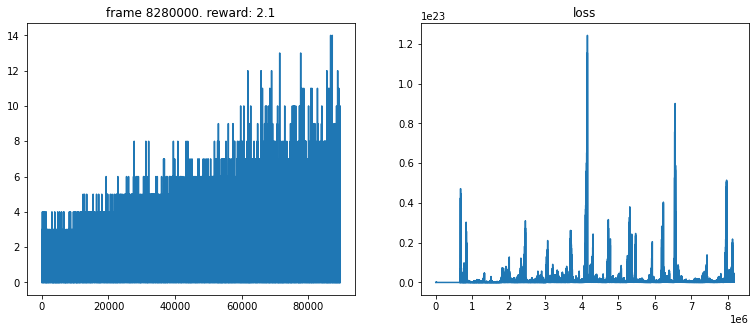

14.0


In [ ]:
# import matplotlib.pyplot as plt
# from pyvirtualdisplay import Display
# display = Display(visible=0, size=(1400, 900))
# display.start()


# is_ipython = 'inline' in plt.get_backend()
# if is_ipython:
#     from IPython import display

# plt.ion()


losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
print(state.shape)
# img = plt.imshow(env.render(mode='rgb_array'))

frame_queue = [np.squeeze(np.array(state),axis = 0)]
reward_queue = [0]
for frame_idx in range(1, num_frames + 1):
    
    epsilon = epsilon_by_frame(frame_idx)
    
    

    if len(frame_queue)!=4:
        action = random.choice(range(4))
        next_state, reward, done, _ = env.step(action)
        frame_queue.append(np.squeeze(np.array(next_state),axis = 0))
        reward_queue.append(reward)
    else:
        state_4frames = np.array([frame_queue[0],frame_queue[1],frame_queue[2],frame_queue[3]])
        # print(state_4frames.shape)
        action = model.act(state_4frames, epsilon)
        next_state, reward, done, _ = env.step(action)
        # print(state_4frames.shape)
        reward_4frames = sum(reward_queue)
        frame_queue.pop(0)
        reward_queue.pop(0)
        frame_queue.append(np.squeeze(np.array(next_state),axis = 0))
        reward_queue.append(reward)
        next_state_4frames = np.array([frame_queue[0],frame_queue[1],frame_queue[2],frame_queue[3]])
        replay_buffer.push(state_4frames, action, reward_4frames, next_state_4frames, done)
        

    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        frame_queue = [np.squeeze(np.array(state),axis = 0)]
        reward_queue = [0]
        # print(episode_reward)
        
        
    if len(replay_buffer) >= replay_initial:
        # print("Hi")
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())
        
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards, losses)
        print(max(all_rewards))
        
    if frame_idx % 1000000 == 0:
        
        torch.save(model.state_dict(),cwd+"/models/dqn.pt")




### Save Model

In [ ]:
torch.save(model.state_dict(),cwd+"/models/dqn.pt")

### Test with Model

In [ ]:
"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
# from gym.wrappers import Monitor
import glob, io, base64


# monitor_logger = logging.getLogger()

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")
    

def wrap_env(env):
    display = Display(visible=0, size=(1400, 900))
    display.start()
    env = Monitor(env, './video/dqn', force=True)
    return env




# model = CnnDQN(env.observation_space.shape, env.action_space.n)
# if torch.cuda.is_available():
#     model = model.cuda()

# model.load_state_dict(torch.load(cwd+"/models/dqn.pt"))


# gym_only_env = wrap_env(gym.make(env_id))
# gym_only_env = wrap_deepmind(gym_only_env)
# gym_only_env = wrap_pytorch(gym_only_env)

# observation = gym_only_env.reset()

# while True:

#     action = model.eval(observation)

#     observation, reward, done, info = gym_only_env.step(action) 
                
#     if done: 
#         break
            
# gym_only_env.close()
# show_video()




In [ ]:
import matplotlib.pyplot as plt
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
import time

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# Load the gym environment

import gym
import matplotlib.pyplot as plt
%matplotlib inline

gym_only_env = wrap_deepmind(gym.make(env_id))
gym_only_env = wrap_pytorch(gym_only_env)

# Let's watch how an untrained agent moves around

model = CnnDQN(env.action_space.n)
if torch.cuda.is_available():
    model = model.cuda()

model.load_state_dict(torch.load(cwd+"/models/dqn.pt"))

state = gym_only_env.reset()
img = plt.imshow(gym_only_env.render(mode='rgb_array'))
for j in range(2000):
    
    
    action = model.eval(state)
    # action = random.choice(range(4))
    # print(gym_only_env.render(mode='rgb_array'))
    print(type(action.cpu()))
    print(action.cpu().item())
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = gym_only_env.step(action.cpu().item())
    # time.sleep(1)
    if done:
        break 
        
env.close()